The company I work for heavily specializes on on self-supervised learning for computer vision, which is why I regularly get to work with *embedding models*. For those unaware, an embedding model is a neural network that maps a sample (e.g. an image or also some text) to a high-dimensional vector (I mean *really* high-dimensional, usually between 512 and 2048 dimensions). While we usually can't make sense of these vectors when they appear in isolation, we can still draw some very nice conclusions when we compare them to each other or apply operations on them. In this article, I would like to demonstrate some operations that can help you make sense of embedding spaces, and can hopefully drive intuition about how neural networks work. It's also really fun to see that your linear algebra classes from school were not in vain.

## Some Theory and Food for Thought
### Classification as a Dimensionality Reduction
Most neural networks are trained to be highly non-linear dimensionaliy reductions (think PCA, but way more sophisticated). This means that they take a high-dimensional input (e.g. an image of $m=256*256=65536$ dimensions) and map it to a lower-dimensional space (e.g. a few dimensions $n$, corresponding to the number of classes in a classification task). 

$$
f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}
$$

To illustrate this, let's assume that we would like to train a neural network to classify images of resolution $32*32=1024$ into 3 classes: cats, dogs, and birds. The model then becomes:
$$
f: \mathbb{R}^{1024} \rightarrow \mathbb{R}^{3}
$$
This means that the last layer outputs a 3-dimensional vector, and since it will be a softmax layer, the output can in particular be written as a linear combination of 3 the unit vectors in $\mathbb{R}^{3}$ with weights that sum to 1:
$$
f(\vec{x}) = w_1 \cdot \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} + w_2 \cdot \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix} + w_3 \cdot \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$$
As training progresses, the neural network will be adjusted such that inputs $\vec{x}$ of the same class start aligning with the same unit vector, i.e. they will be closely mapped together in the space.

### Embedding Models
Now of course, being able to classify images into 3 classes is nice, but we would like to encode much more information about our images in the output of our network. For example should the output of our network be different if the background is different etc. This is exactly what embedding models are supposed to do: They try to compress all the information into a (relatively) compact vector, beyond single classes. Contrary to the classification task from before, the output space of these models is not directly interpretable, i.e. we don't know beforehand where in the space the cats, dogs and birds will end up – in the classification case we knew that, because there was a single neuron that was responsible for identifying cats, dogs or birds. Now it's instead going to be a complicated linear combination of all the neurons in the last layer that will determine these things. What still holds true however, is the fact that similar inputs will be mapped to similar vectors in the output space. This let's us use the outputs to directly compare the similarities between inputs, which was prohibitely expensive to do directly in the input space!

Embedding models for images are usually trained through [*self-supervised learning*](https://en.wikipedia.org/wiki/Self-supervised_learning), a machine learning paradigm where the model targets are directly derived from the input data itself. For language, *autoregressive* models are usually applied for this purpose (i.e. RNNs or Transformers that predict the next token). For images, the most commonly used paradigms of self-supervised learning are *contrastive learning*, *masked image modeling* and *self-distillation*. Particularly contrastive learning has also been extended for jointly learning image and text embeddings and the prime example of such models is CLIP (Contrastive Language-Image Pretraining). This model not only maps images to abstract embedding vectors, but can also map text to the same space. As we will see in the next sections, this allows drawing some very interesting conclusions about the relationships between images and text.

## Dataset
We will be working with the CelebHQ dataset, a well known dataset of celebrity faces. I found this to be particularly useful for this article, because the images are close to each other in terms of content, but we as humans have very succinct language to describe differences between them (think gender, age, skin color, hair color, etc.). In order to speed up the embedding process a bit we use a subsampled variant of the dataset, where the images have been resized to 256x256 pixels.

You can download the dataset as follows:

In [4]:
import os

if not os.path.exists("celebhq256.zip"):
    !curl -L -o celebhq256.zip https://www.kaggle.com/api/v1/datasets/download/badasstechie/celebahq-resized-256x256
    !unzip celebhq256.zip
else:
    print("celebhq256.zip already exists.")

celebhq256.zip already exists.


## Embedding our Dataset
In order to create vector embeddings for the images in our dataset, we will first have to install some dependencies that we need to run CLIP.

In [ ]:
!pip install transformers torch pillow matplotlib scikit-learn umap-learn

Now we can instantiate the CLIP model and save the embedings to our disk. I will also save the image paths to a JSON file, so that we can easily load embeddings and images together later on.

In [3]:
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import glob
import json
import os

device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32", 
    torch_dtype=torch.bfloat16, 
).to(device)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

imgs = glob.glob("celeba_hq_256/*.jpg")
embeddings = torch.empty((len(imgs), 512), dtype=torch.float32).to(device)
embeddings_file = "celebhq256_embeddings.pt"
imgs_json_file = "celebhq256_filepaths.json"

if not (os.path.exists(embeddings_file) and os.path.exists(imgs_json_file)):
    for i, img in enumerate(imgs):
        image = Image.open(img).convert("RGB")
        inputs = processor(images=[image], return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        embeddings[i] = outputs.squeeze()
    
    torch.save(embeddings, embeddings_file)
    with open(imgs_json_file, "w") as f:
        f.write(json.dumps({"filepaths": imgs}))
else:
    embeddings = torch.load(embeddings_file, map_location=device)
    with open(imgs_json_file, "r") as f:
        imgs = json.load(f)["filepaths"]

print(f"Embeddings shape: {embeddings.shape}")
print(f"Number of images: {len(imgs)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Embeddings shape: torch.Size([30000, 512])
Number of images: 30000


Now we will create a small helper function that will allow us to easily embed any text we want. Once we have this function, we will be able to basically to linear algebra with images and text!

In [4]:
import numpy as np

def vec(text: str) -> np.ndarray:
    """Encode text into a numpy vector of shape (512,)."""
    inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    return outputs.squeeze().float().cpu().numpy()

Let's also create small helper functions that let us easily extract a few random image embeddings together with their correcsponding images.

In [5]:
from PIL.Image import Image as PILImage
from PIL import Image
import numpy as np

def get_emb_and_img(index: int) -> tuple[np.ndarray, PILImage]:
    """Get the embedding and image path for a given index."""
    return embeddings[index].cpu().numpy(), Image.open(imgs[index]).convert("RGB")

def sample_random(n: int) -> list[tuple[np.ndarray, PILImage]]:
    """Sample n random images and their embeddings."""
    indices = np.random.choice(len(imgs), n, replace=False)
    return [get_emb_and_img(i) for i in indices]

## Visualizing the Embedding Space with Clustering
Now the fun begins! As said earlier, embedding spaces are high-dimensional and therefore difficult to interpret or visualize. In order to make sense of them, we first need to project them onto a much smaller number of dimensions. Two very common methods for this dimensionality reduction are *t-SNE* and *UMAP*. Both methods are very good at preserving the local structure of the data, i.e. they will try to keep similar points close together in the lower-dimensional space.

/home/lionel/Documents/mlblog/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


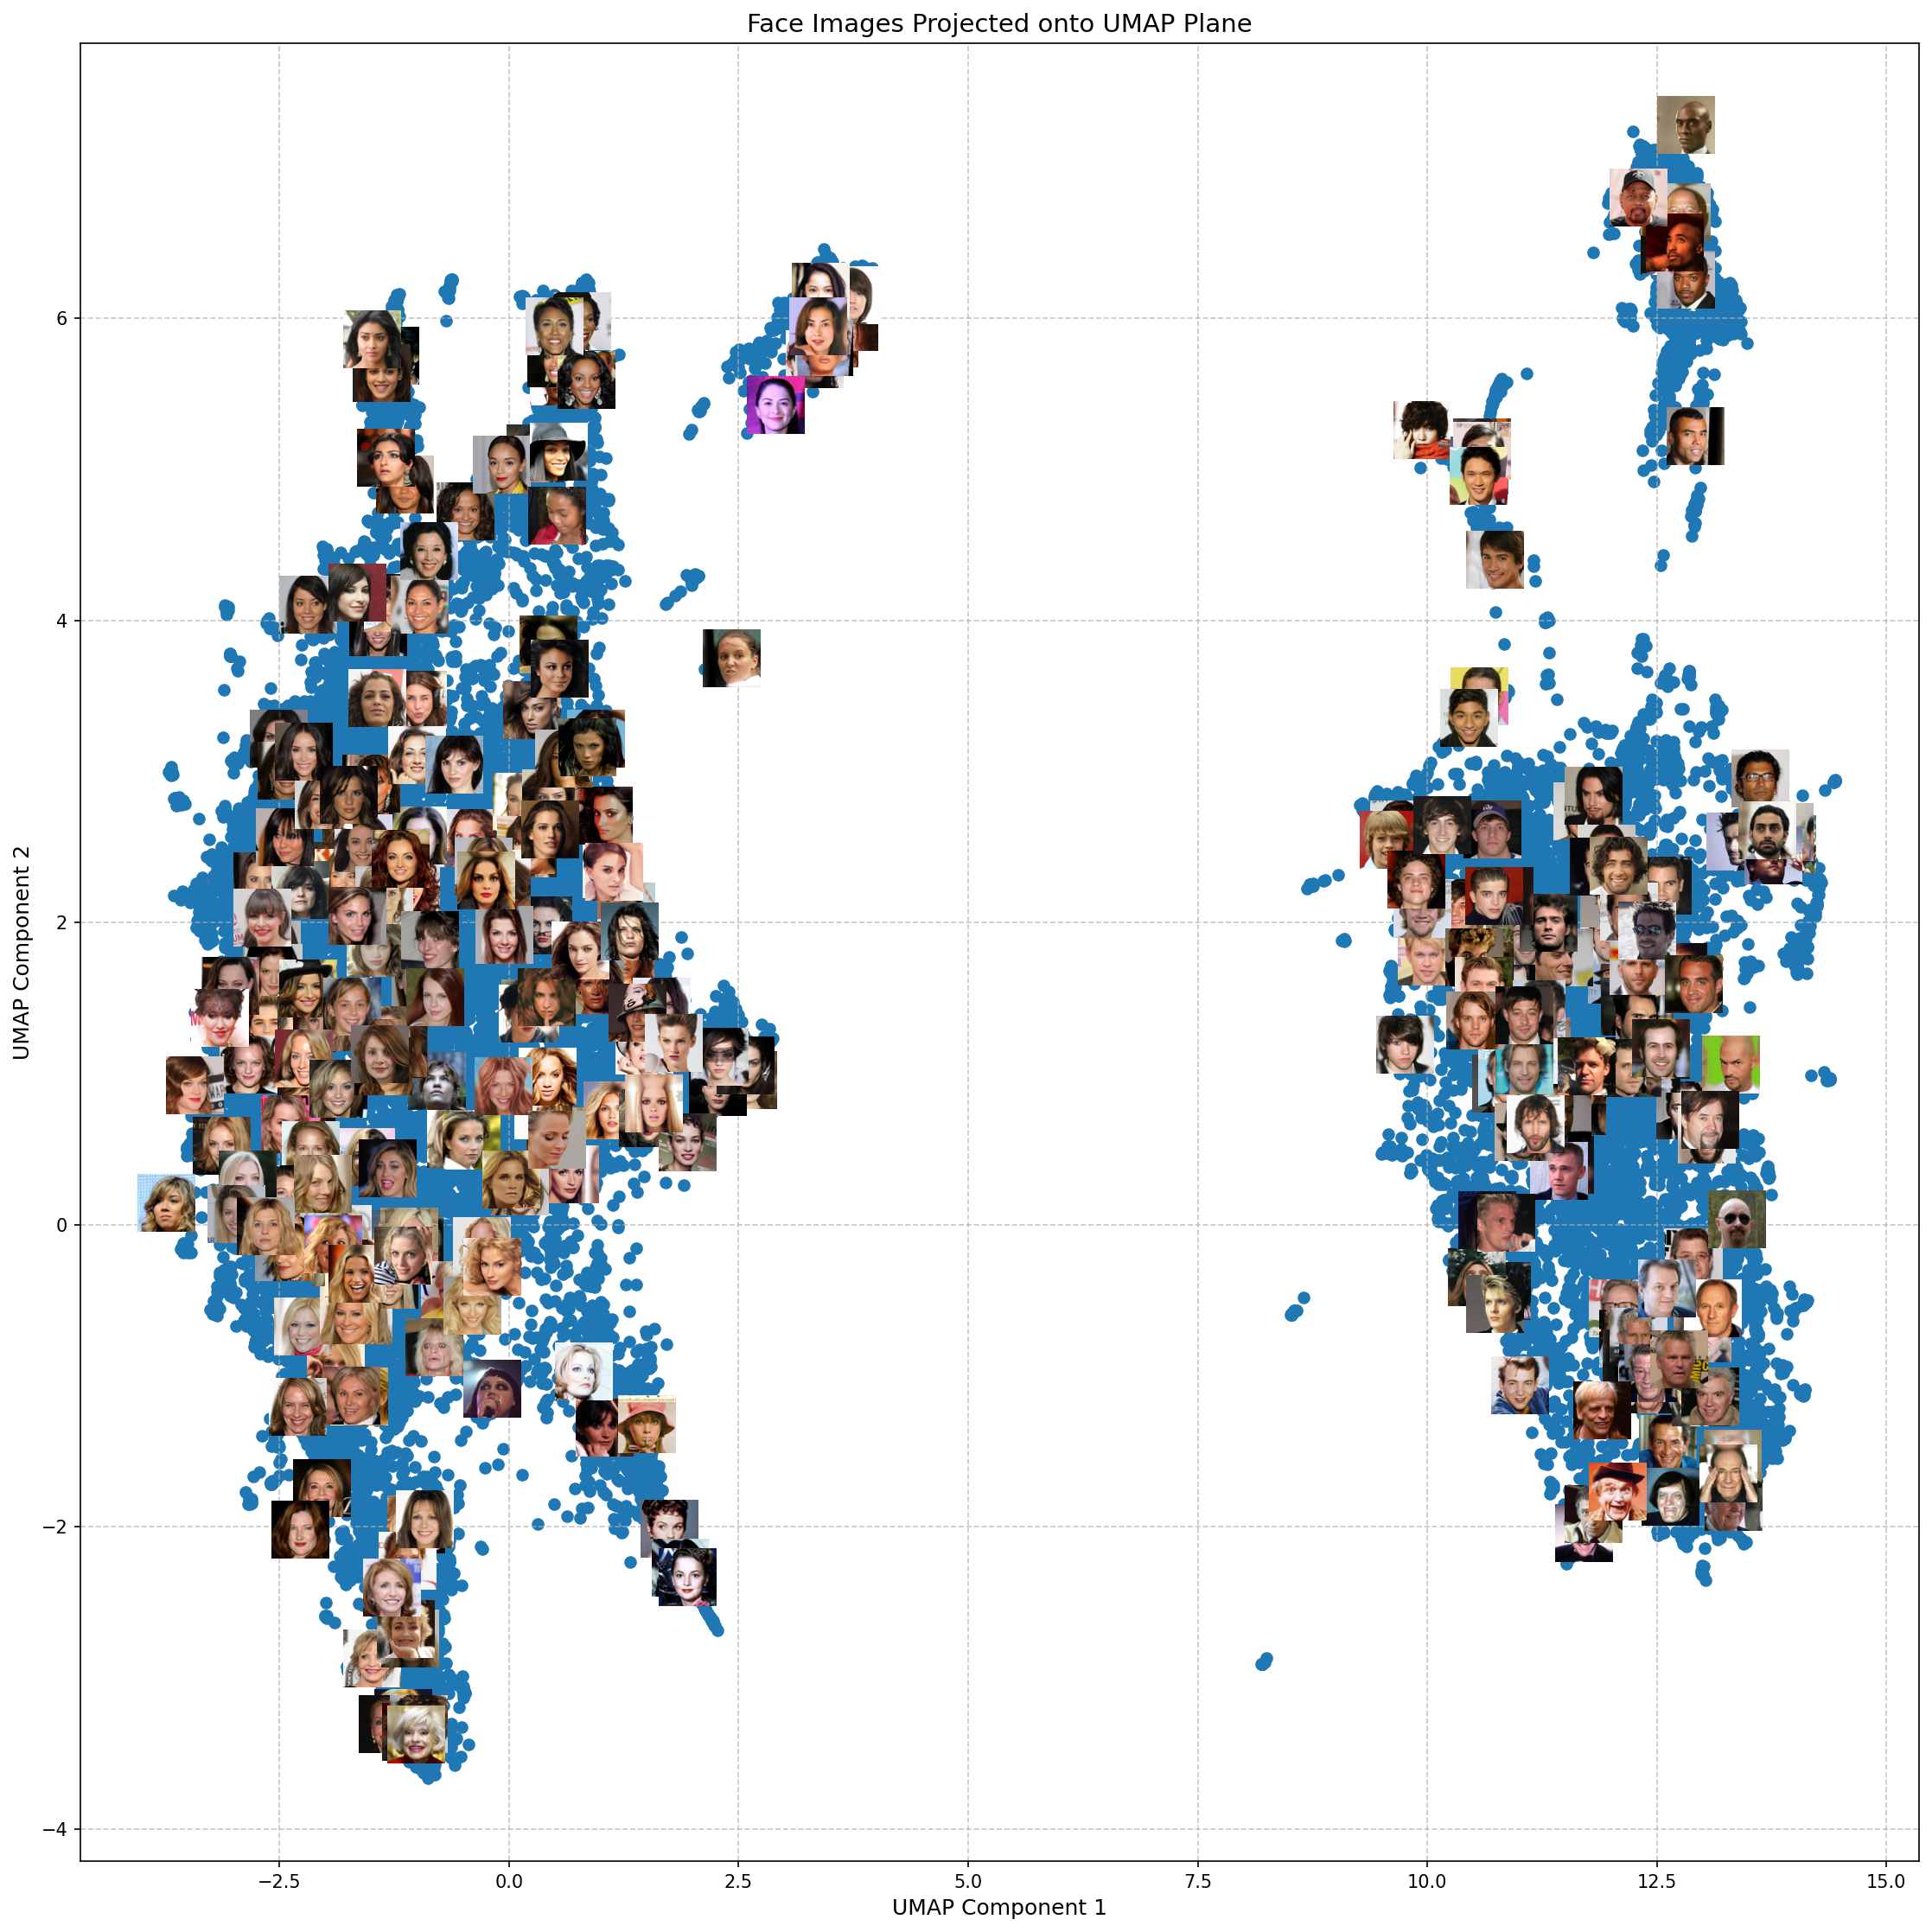

In [ ]:
import matplotlib.pyplot as plt
from umap import UMAP
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import PIL.Image as Image

umap = UMAP(n_components=2).fit_transform(embeddings.cpu().numpy())
fig, ax = plt.subplots(figsize=(15, 15), dpi=150)
scatter = ax.scatter(umap[:,0], umap[:,1])

# Add images as markers for some of the embeddings
for i, (x0, y0) in enumerate(zip(umap[:,0], umap[:,1])):
    if i % 100 != 0:  # Skip most images for performance
        continue
    _, img = get_emb_and_img(i)
    # Resize image to be smaller
    img.thumbnail((64, 64), Image.Resampling.LANCZOS)
    # Create offset image and annotation box
    im = OffsetImage(img, zoom=0.5)
    im.image.axes = ax
    ab = AnnotationBbox(
        im, 
        (x0, y0), 
        xycoords='data', 
        frameon=False, 
        box_alignment=(0.5, 0.5)
    )
    ax.add_artist(ab)

ax.set_xlabel("UMAP Component 1", fontsize=12)
ax.set_ylabel("UMAP Component 2", fontsize=12)
ax.set_title("Face Images Projected onto UMAP Plane", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

As you can see, the projection onto the 2 dimensions extracted by UMAP is very good at preserving the local structure of the data and we can therefore clearly see clusters emerge, e.g. two large clusters of males and females, as well as smaller clusters that separate by race.

Beyond having an algorithm decide the two axes for us, we can also manually select them ourselves. This is what we will do in the next section, where we will extract *semantic directions* from the embedding space and use them to create a more interpretable visualization.

## Visualizing the Embedding Space with Semantic Directions
In the previous section, we saw that the embedding space is very good at separating different groups of people and we were pretty sure that the horizontal axis separated by gender. However, the vertical axis was more ambiguous. We will therefore now try to create the desired axes ourselves, by extracting *semantic directions*. Semantic directions are vectors that point in the direction of which a specific property changes the quickest, i.e. they are basically the gradient of a property in the embedding space. For example, if we want to extract the direction in which the *gender* changes the quickest, we should probably find the vector that points from the *manliest man* to the *most feminine female*. We can get this vector through simple vector subtraction, like we learned in school:

$$
\begin{equation}
\vec{d_{gender}} = \vec{x_{feminine}} - \vec{x_{masculine}}
\end{equation}
$$

As you might remember, this gives us a vector that points from masculine to feminine. We will now go ahead and extract this vector. Additionally, we will also extract a semantic direction encoding the *age* of the person and then we will again visualize the embedding space, but this time using these two semantic directions as axes. For projecting the embeddings, we can of course utilize a simple dot product, which will give us the projection of the embedding onto the semantic direction vector.

In [18]:
import numpy as np
from numpy import random

gender_direction = vec("feminine woman") - vec("masculine man")
age_direction = vec("child") - vec("grandparent")

projection_plane = np.stack((gender_direction, age_direction), axis=0)
imgs_embs = sample_random(n=1000)
sampled_embs = np.stack([emb for emb, _ in imgs_embs])
sample_imgs = [img for _, img in imgs_embs]

def project_onto_plane(embeddings: np.ndarray, plane: np.ndarray) -> np.ndarray:
    return embeddings @ plane.T

projections = project_onto_plane(sampled_embs, projection_plane)

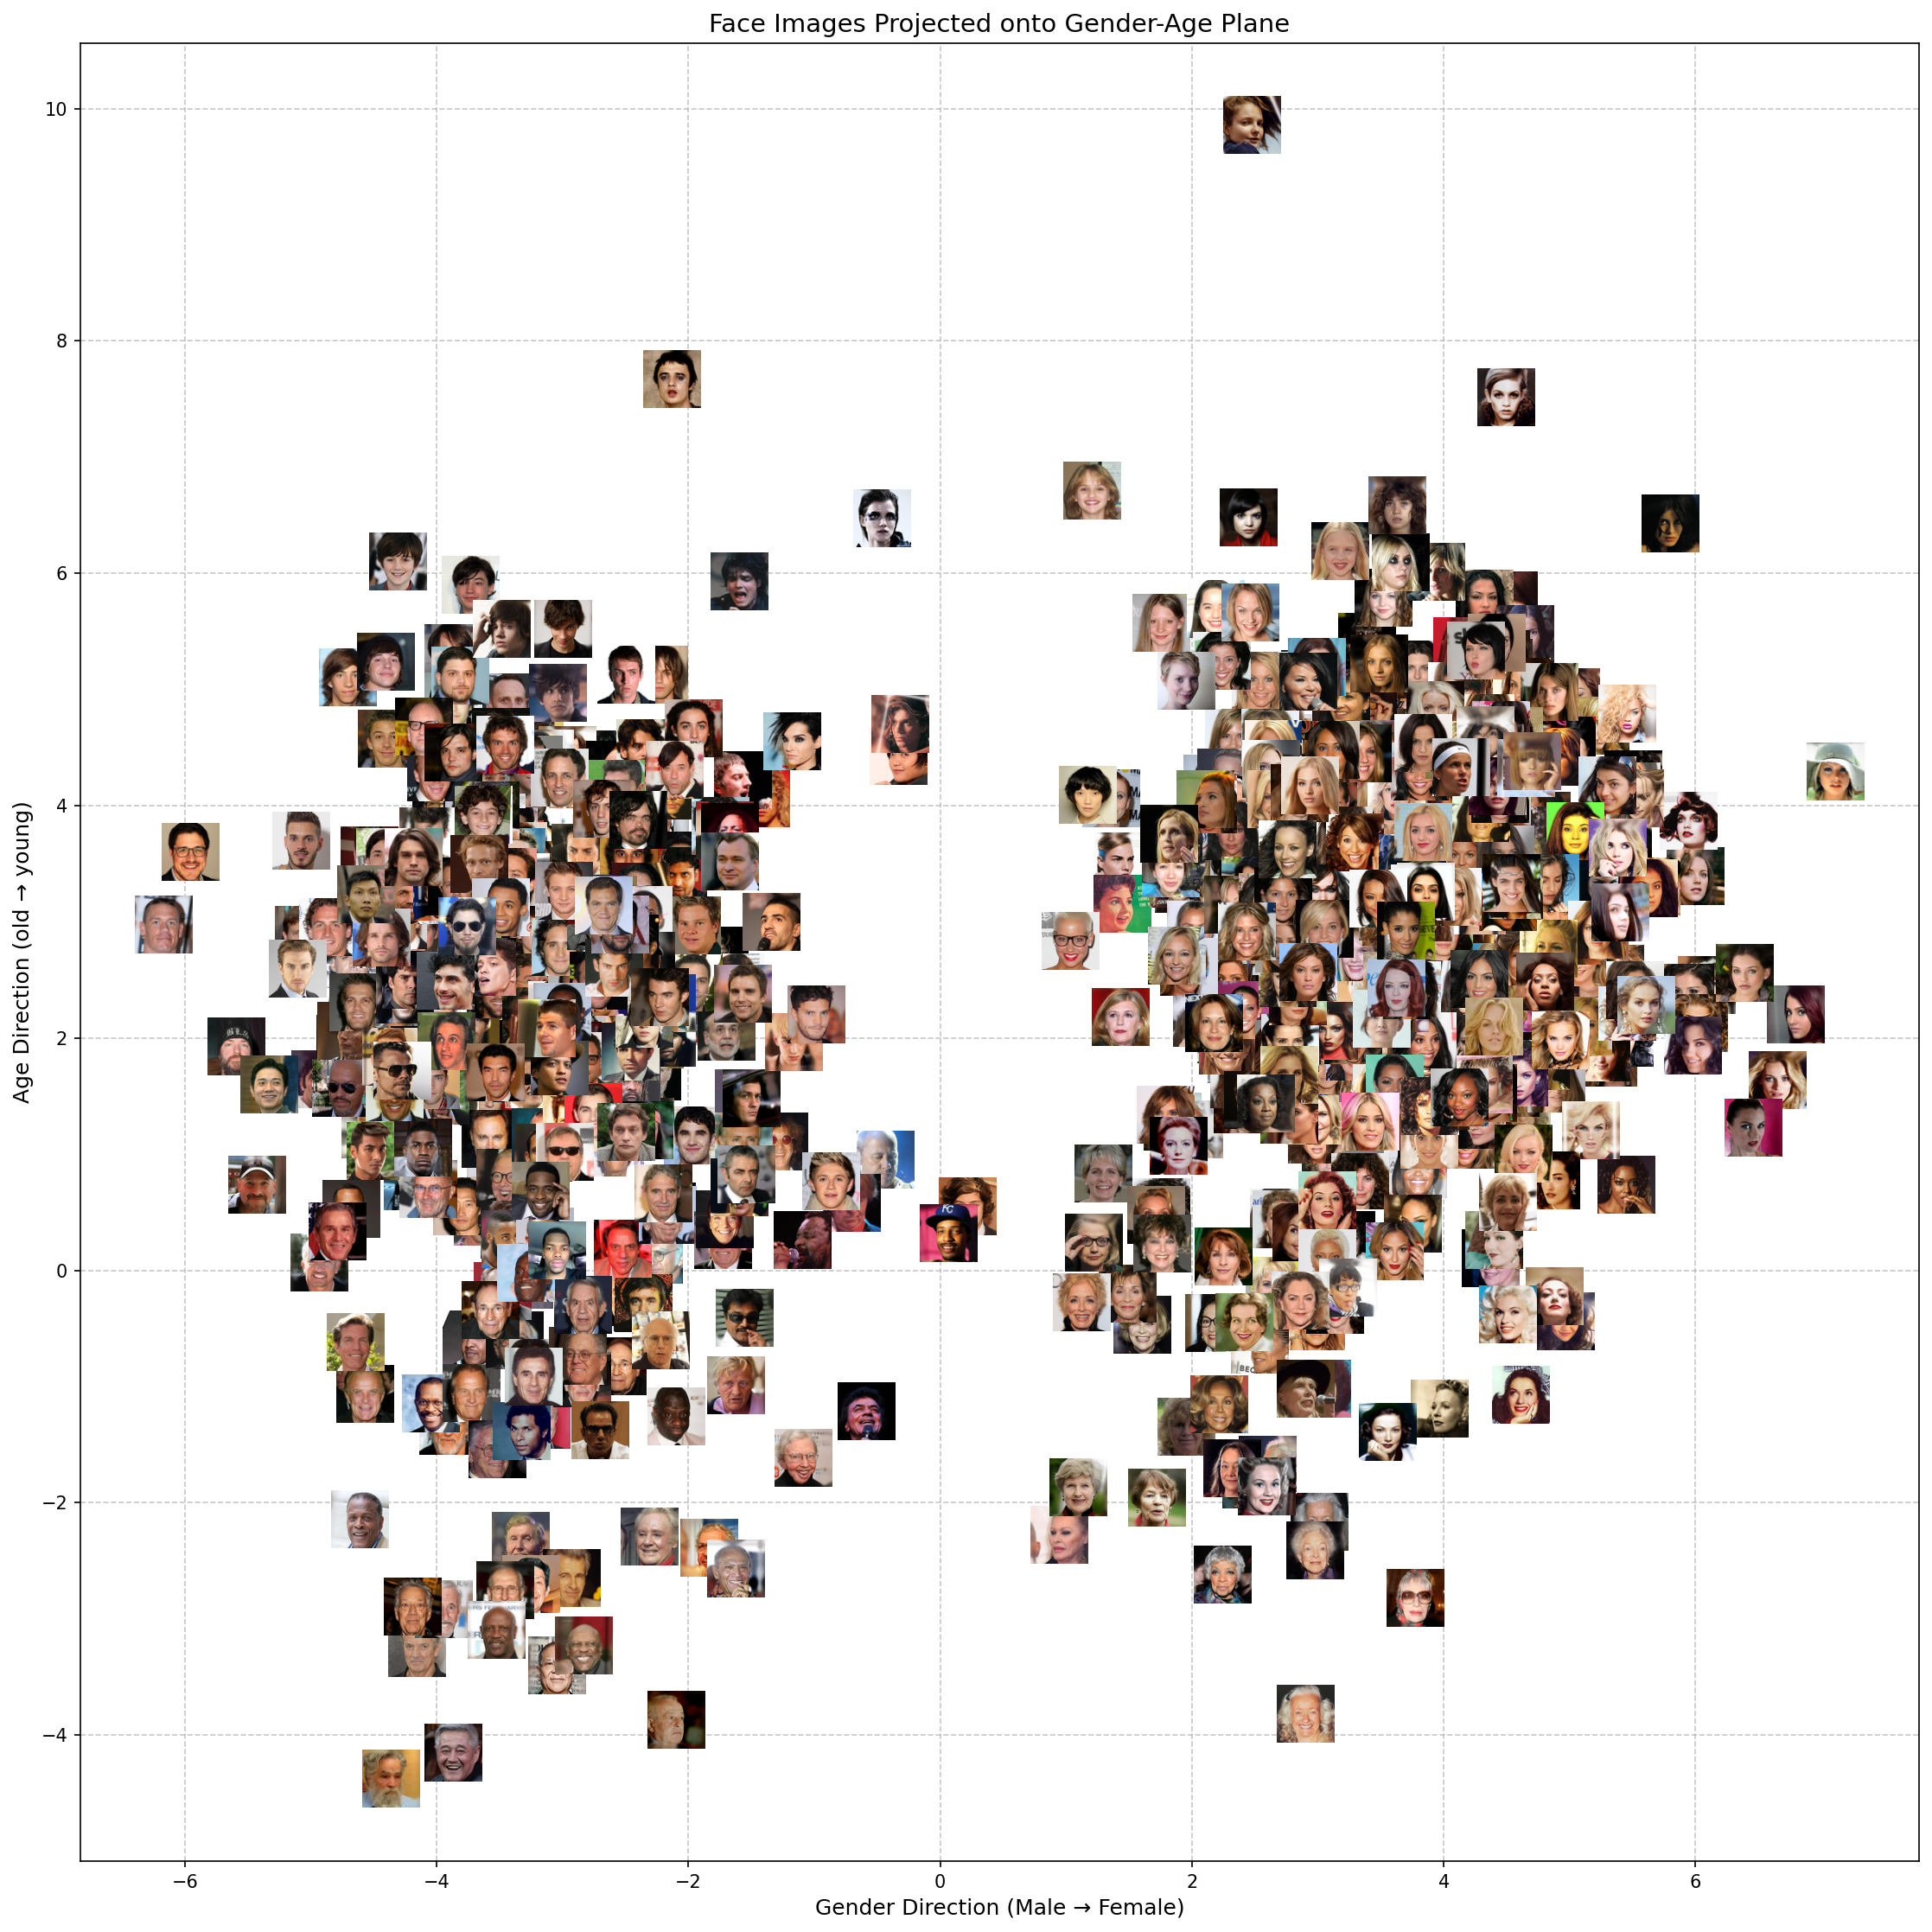

In [20]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import PIL.Image as Image

fig, ax = plt.subplots(figsize=(15, 15), dpi=150)
scatter = ax.scatter(projections[:,0], projections[:,1], alpha=0)

# Add images as markers
for x0, y0, img in zip(projections[:,0], projections[:,1], sample_imgs):
    # Resize image to be smaller
    img.thumbnail((64, 64), Image.Resampling.LANCZOS)
    # Create offset image and annotation box
    im = OffsetImage(img, zoom=0.5)
    im.image.axes = ax
    ab = AnnotationBbox(im, (x0, y0),
                       xycoords='data',
                       frameon=False,
                       box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

ax.set_xlabel("Gender Direction (Male → Female)", fontsize=12)
ax.set_ylabel("Age Direction (old → young)", fontsize=12)
ax.set_title("Face Images Projected onto Gender-Age Plane", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

As you can see, this worked pretty damn well! Your creativity to play around with semantic directions is basically unlimited and it's a really fun way to explore how embedding spaces work. A fun direction to try with humans for example is *coolness* or *sex-appeal*. And you can of course also try extracting semantic directions on other datasets where other properties are more relevant. I hope you'll have fun explore the endless possibilities of embedding spaces!